In [1]:
%reload_ext autoreload
%autoreload 2
import warnings
warnings.filterwarnings('ignore')

import pyxdf
import os
import numpy as np
from scipy import stats
from scipy.signal import medfilt, resample, butter, sosfilt
from pathlib import Path
import sys
from datetime import datetime
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.collections import PolyCollection
from matplotlib.gridspec import GridSpec
from tueplots import axes, bundles
from astropy.convolution import Gaussian1DKernel, convolve_fft
from mne.time_frequency import psd_array_welch
from mne import set_log_level
set_log_level('WARNING')

# Increase the resolution of all the plots below
bundles.beamer_moml()
plt.rcParams.update({"figure.dpi": 200,"figure.facecolor":"w","figure.figsize": (15,10)})


from utilities.utl import find_lsl_stream, find_nearest, fill_nan, axlines_with_text, polygon_under_graph
from utilities.SingleSubjectData import SubjectData, Epochs

In [2]:
# (import) helper functions
dir_script = Path("__file__").parent.absolute()
dir_rawdata = Path.joinpath(dir_script.parent.absolute(), "04_data","00_raw")
dir_plots = Path.joinpath(dir_script.parent.absolute(),"06_plots","01_single_trial")
dir_prep = Path.joinpath(dir_script.parent.absolute(),"04_data","01_prep")
print(dir_script)

c:\Users\User\Desktop\kiel\tremor_feedback_jw\05_scripts


In [3]:
f_list = os.listdir(dir_rawdata)
str_match = 'archer'
fnms = [s for s in f_list if str_match in s]
print([f.split('_')[0] for f in fnms])

['c301', 'c302', 'c303', 'c304', 'c305', 'c306', 'c307', 'c308', 'c309', 'c310', 'p200', 'p201', 'p202', 'p203', 'p204', 'p205', 'p206', 'p207', 'p208', 'p209', 'p210', 'p211', 'p212', 'p213', 'p214', 'p215']


In [4]:
# set params for epoch processing and plotting
cfg_gss_plot_colors = plt.cm.viridis(np.linspace(0,1,3))
cfg_trial_times = [5,25]
cfg_trial_times.sort()
cfg_epoch_times =  [0,30]
cfg_epoch_times.sort()
cfg_plot_lw = 1.5
cfg_bp_filt = (1,15)
cfg_freq_oi_trmr = (3.5,12)
cfg_freq_oi_mov = (1,3)

if np.max(cfg_trial_times) > np.diff(cfg_epoch_times):
    raise ValueError ('Time window of interest ouside epoch length')

# prelocate variables
tmp_fnms = fnms
# tmp_fnms =  [nm for nm in fnms if "p208" in nm] * 2
print([f.split('_')[0] for f in tmp_fnms])

id = []
n_trial = []
con_view_ang = []
con_feedback = []
all_m_psds_trmr = []
all_m_psds_mov = []
all_psds_trmr = []


for f in tmp_fnms:

    sub = SubjectData()
    sub.load_data(dir_rawdata,f)

    if not sub.fsr:
        print(f'No GSS data found for {sub.id}')
        continue
        
    # prep raw 
    tmp_dat = medfilt(sub.fsr["time_series"][:,0],3)

    # epoch data
    eps = Epochs(sub,tmp_dat,times=sub.fsr["time_stamps"], events=sub.mrk, srate = 80, max_force = sub.max_force)
    eps.data = eps.data / eps.max_force

    # do epoching of data
    idx_exp_start   = eps.events[eps.events["value"].str.match('block1')].index[0]
    eps.epoch('trial_start*', idx_start=idx_exp_start,tmin=cfg_epoch_times[0],tmax=cfg_epoch_times[1],resample_epochs=True)  
    
    # define cfgs from loaded epochs
    cfg_filter = butter(10, cfg_bp_filt, 'bp', fs=eps.srate, output='sos')
    cfg_epoch_timevec = eps.times
    cfg_gss_psd_colors = plt.cm.viridis(np.linspace(0,1,eps.data.shape[2]))

    # zscore per condition
    # extract viewing angle from epoch object 
    tmp_view_angle = eps.events["value"][eps.events["value"].str.contains('sfb') ].str.split('_').str[3].astype(float).round(2)
    psds_trmr = []
    psds_mov = []

    # prep figre
    fig = plt.figure(constrained_layout=True)
    gs = GridSpec(3, 2, figure=fig)
    ax1 = fig.add_subplot(gs[0, 0])
    ax2 = fig.add_subplot(gs[1, 0])
    ax3 = fig.add_subplot(gs[2, 0])
    ax5 = fig.add_subplot(gs[:,1], projection = '3d')


    # prep single trial force data
    for i in range(eps.data.shape[2]):
        
        # append for overview
        id.append(sub.id)
        n_trial.append(i)

        # set plotting style for each epoch conditions
        if tmp_view_angle.iloc[i] == .02:
            ls = 'dotted'
        elif tmp_view_angle.iloc[i] == .44:
            ls = 'solid'

        if 0 <= i < 4:
            tmp_color = cfg_gss_plot_colors[0]      
            tmp_label = 'visual'
            ax1.plot(cfg_epoch_timevec,eps.data[0,:,i],color=tmp_color,linewidth=cfg_plot_lw, alpha=.5, linestyle = ls)
        elif 4 <= i < 8:
            tmp_color = cfg_gss_plot_colors[1] 
            tmp_label = 'auditiv-visual'
            ax2.plot(cfg_epoch_timevec,eps.data[0,:,i],color=tmp_color,linewidth=cfg_plot_lw, alpha=.5, linestyle = ls)
        elif 8 <= i <12:
            tmp_color = cfg_gss_plot_colors[2]
            tmp_label = 'auditiv'      
            ax3.plot(cfg_epoch_timevec,eps.data[0,:,i],color=tmp_color,linewidth=cfg_plot_lw, alpha=.5, linestyle = ls)
           
        idx_times_oi = np.logical_and(eps.times>=cfg_trial_times[0], eps.times<=cfg_trial_times[1])
        filt_trmr = sosfilt(cfg_filter, eps.data[0,idx_times_oi,i])
        tmp_psd_trmr, freqs_trmr = psd_array_welch(filt_trmr, eps.srate, fmin=cfg_freq_oi_trmr[0],fmax=cfg_freq_oi_trmr[1], n_fft=eps.srate*3, n_per_seg=eps.srate*3, n_overlap=eps.srate)
        tmp_psd_mov, freqs_mov = psd_array_welch(filt_trmr, eps.srate, fmin=cfg_freq_oi_mov[0],fmax=cfg_freq_oi_mov[1], n_fft=eps.srate*3, n_per_seg=eps.srate*3, n_overlap=eps.srate)
        psds_trmr.append(tmp_psd_trmr)
        psds_mov.append(tmp_psd_mov)
        ax5.plot(freqs_trmr, tmp_psd_trmr.T, zs=i, zdir='y', lw=2, color=cfg_gss_psd_colors[i], alpha=1)


    ep_range = range(len(psds_trmr))
    verts = [polygon_under_graph(freqs_trmr, psd.T) for psd in psds_trmr]
    poly = PolyCollection(verts, facecolors=cfg_gss_psd_colors, alpha=.7)
    ax5.add_collection3d(poly, zs=ep_range, zdir='y')
            
    # plot distribution and scatter 
    m_psds_trmr = [np.mean(p.T[np.logical_and((freqs_trmr>=cfg_freq_oi_trmr[0]) , (freqs_trmr<=cfg_freq_oi_trmr[1]))]) for p in psds_trmr]
    m_psds_mov = [np.mean(p.T[np.logical_and((freqs_mov>=cfg_freq_oi_mov[0]) , (freqs_mov<=cfg_freq_oi_mov[1]))]) for p in psds_mov]

    # set line for raw force data
    axlines_with_text(ax1,.15, 'Target force', axis='y')
    axlines_with_text(ax2,.15, 'Target force', axis='y')
    axlines_with_text(ax3,.15, 'Target force', axis='y')
    
    ax1.set_ylabel('Raw force [a.u.]')
    ax2.set_ylabel('Raw force [a.u.]')
    ax3.set_ylabel('Raw force [a.u.]')

    ax3.set_xlabel('Time[s]')
    ax2.sharex(ax3)
    ax1.sharex(ax3)
    ax1.set_xlim(cfg_trial_times)
    ax2.set_xlim(cfg_trial_times)
    ax3.set_xlim(cfg_trial_times)
    ax1.autoscale(enable=True, axis='y', tight=True)
    ax2.autoscale(enable=True, axis='y', tight=True)
    ax3.autoscale(enable=True, axis='y', tight=True)

    ax5.set_xlim(2,14)
    ax5.view_init(35, -80)
    ax5.set_xlabel('Frequency [Hz]')
    ax5.set_zlabel(r'PSD [$\dfrac{V^2}{Hz}$]')
    ax5.set_ylabel('Trial number')

    fig.savefig(Path.joinpath(dir_plots,f"{sub.id}_gss_all.png"))
    fig.clf()
    plt.close('all')

    # info per epoch
    con_view_ang.extend(tmp_view_angle)
    con_feedback.extend(eps.events["value"][eps.events["value"].str.contains('epoch') ].str.split('_').str[1])
    all_m_psds_trmr.extend(m_psds_trmr)
    all_m_psds_mov.extend(m_psds_mov)
    all_psds_trmr.extend(psds_trmr)




['c301', 'c302', 'c303', 'c304', 'c305', 'c306', 'c307', 'c308', 'c309', 'c310', 'p200', 'p201', 'p202', 'p203', 'p204', 'p205', 'p206', 'p207', 'p208', 'p209', 'p210', 'p211', 'p212', 'p213', 'p214', 'p215']
Max force is 5894 something for c301
Stream pupil_capture not found
Max force is 6856 something for c302
Max force is 8514 something for c303
Max force is 5598 something for c304
Max force is 8067 something for c305
Max force is 7033 something for c306
Max force is 9657 something for c307
Max force is 12737 something for c308
Max force is 12044 something for c309
Max force is 9064 something for c310
Max force is 15983 something for p200
Max force is 9105 something for p201
Max force is 4625 something for p202
Max force is 7724 something for p203
Max force is 4975 something for p204
Max force is 6563 something for p205
Max force is 7232 something for p206
Max force is 11349 something for p207
Max force is 9584 something for p208
Max force is 6277 something for p209
Max force is 128

In [5]:
all_trials = {"ID": id, "Trial n": n_trial, "Feedback type": con_feedback, "Feedback angle": con_view_ang, "Power [4-12]": all_m_psds_trmr, "Power [1-3]": all_m_psds_mov}
all_trials = pd.DataFrame(all_trials)


# convert float to categorical
all_trials["Feedback angle"] = all_trials["Feedback angle"].astype(str).map({'0.02': 'low', '0.44': 'high'})
all_trials["Group"] = all_trials["ID"].str[0]
fname = "all_trials_gss.csv"

# delete file before saving
if Path.joinpath(dir_prep,fname).is_file():
    Path.joinpath(dir_prep,fname).unlink()
all_trials.to_csv(Path.joinpath(dir_prep,fname))

<AxesSubplot:xlabel='Feedback type', ylabel='Power [4-12]'>

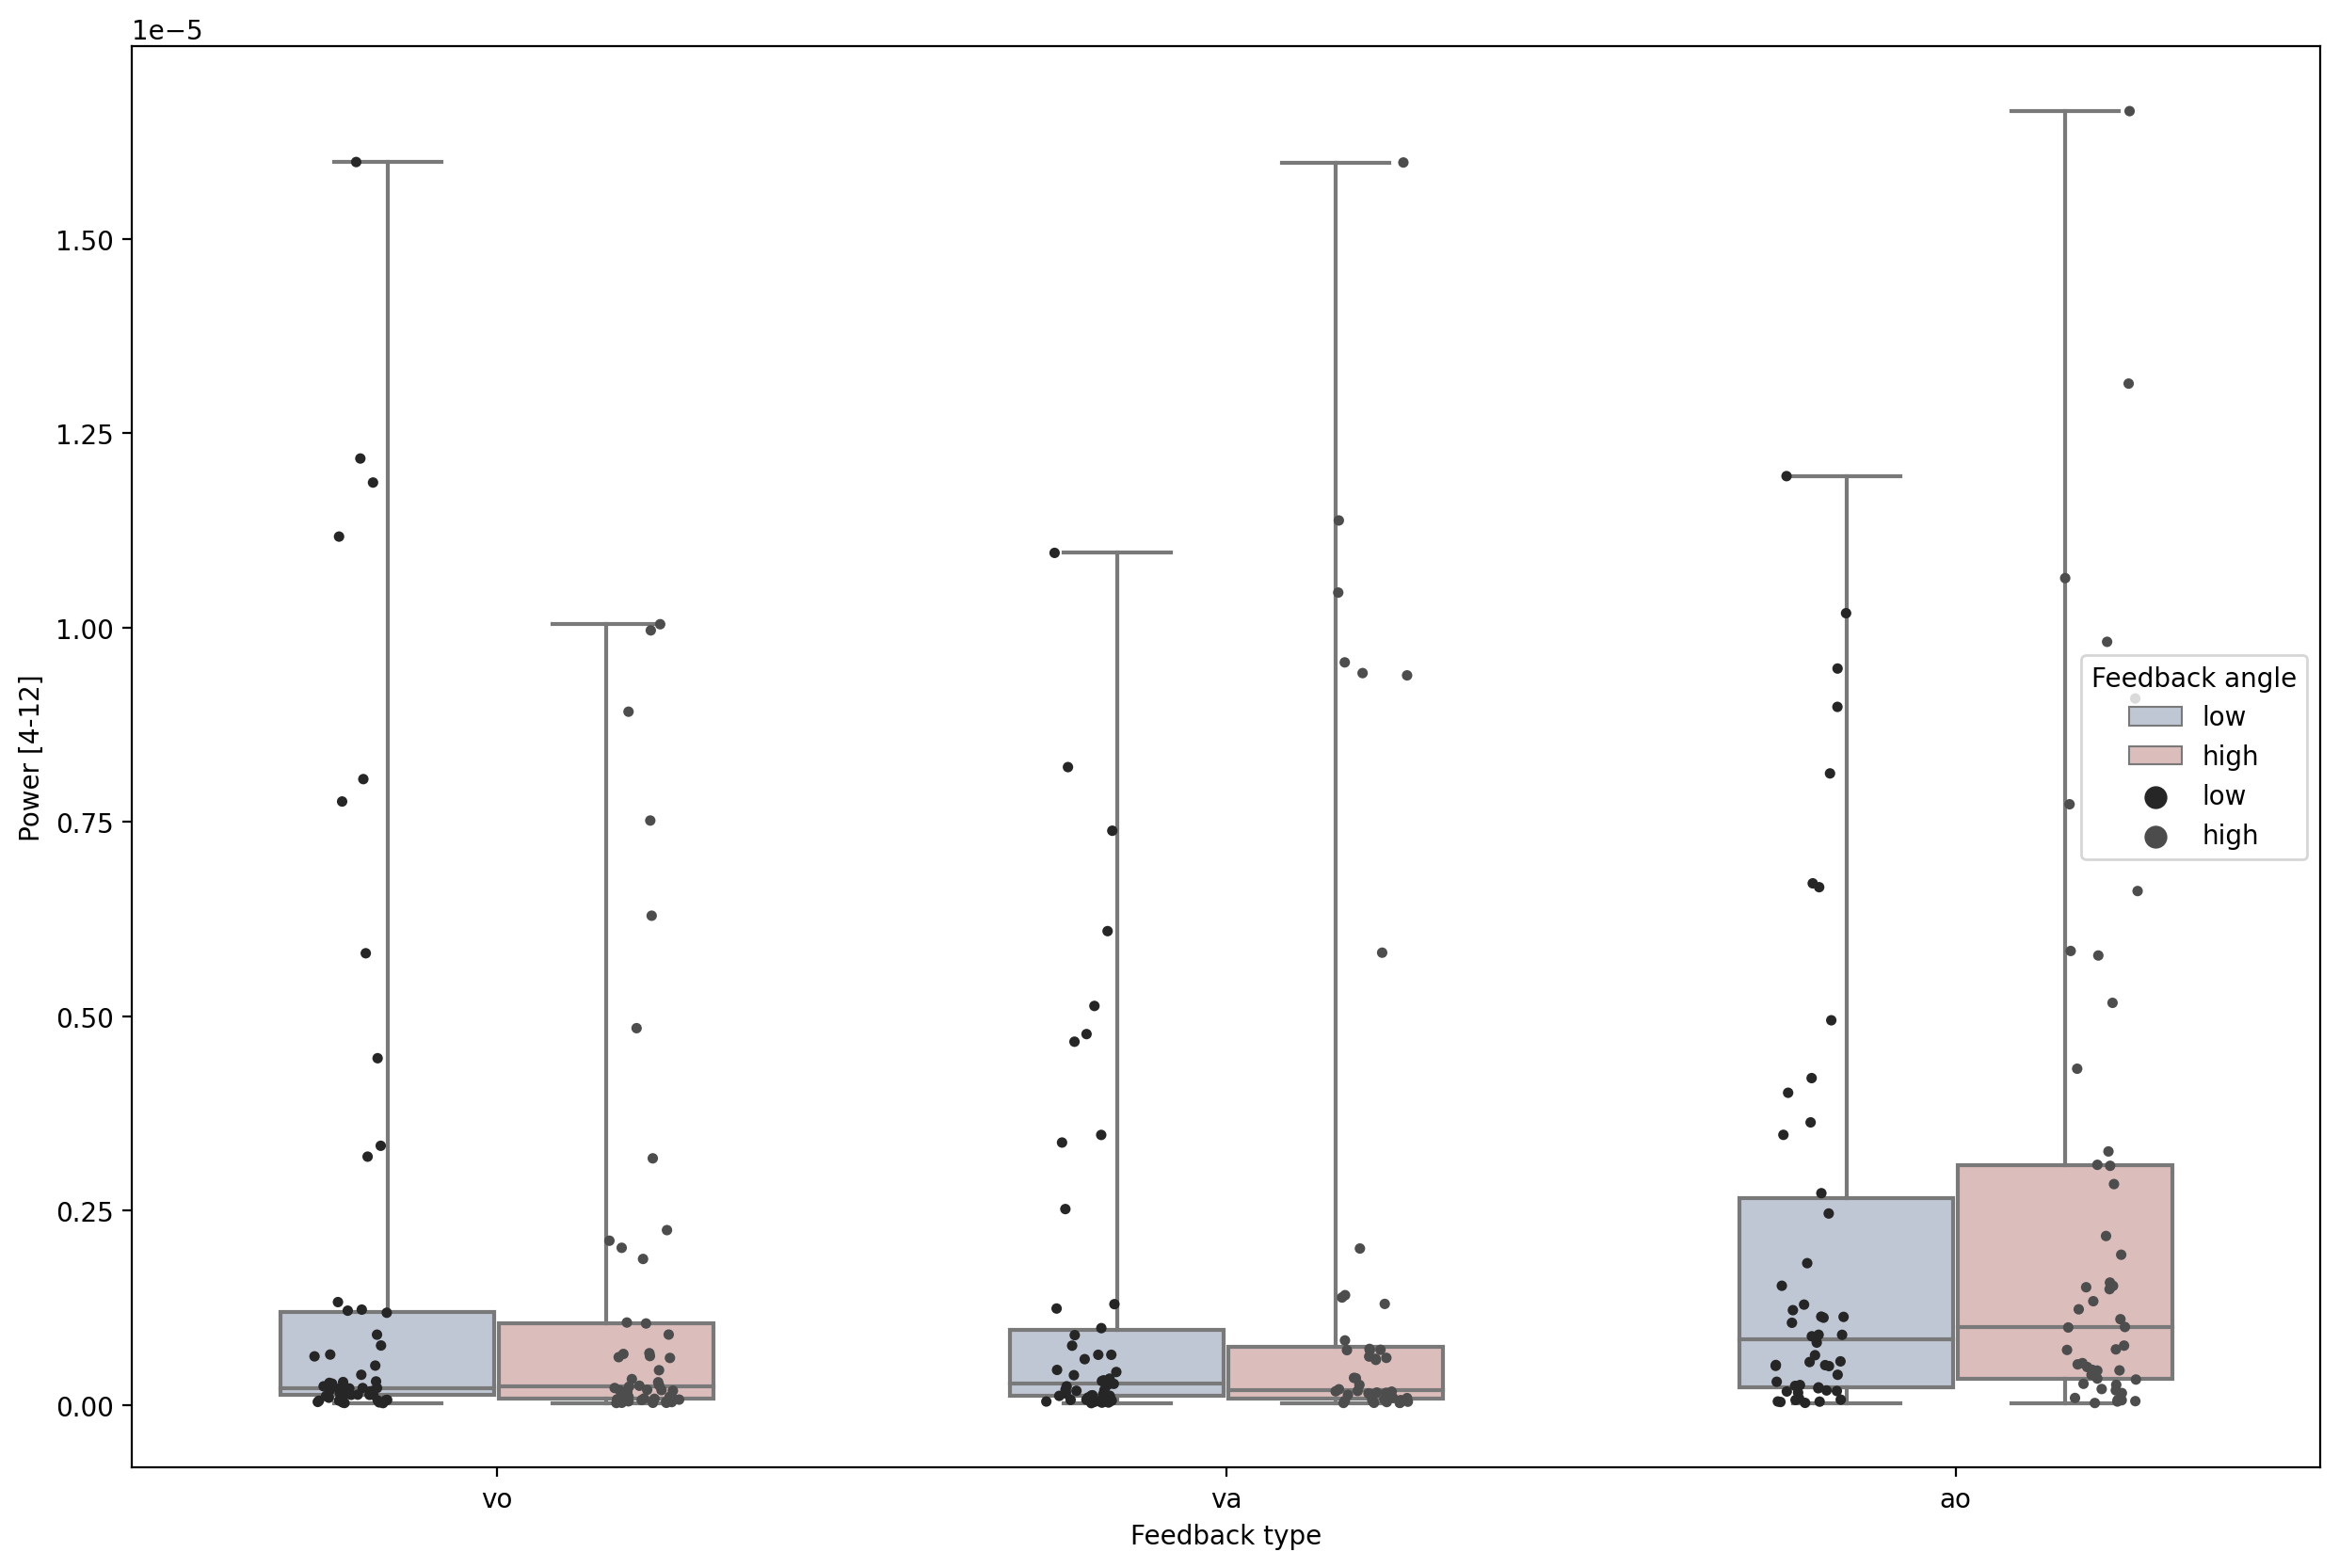

In [6]:
import seaborn as sns

sns.boxplot(data=all_trials.loc[all_trials['Power [4-12]'] < 0.00002],x="Feedback type",y="Power [4-12]",hue="Feedback angle",whis=[0, 100], width=.6,palette="vlag")
sns.stripplot(data=all_trials.loc[all_trials['Power [4-12]'] < 0.00002],x="Feedback type",y="Power [4-12]",hue="Feedback angle",size=4, color=".3", linewidth=0,dodge=True)



## Check termor quality
Now we go on to check the tremor quality in patients force data

In [7]:
all_trials.head()

,ID,Trial n,Feedback type,Feedback angle,Power [4-12],Power [1-3],Group
0,c301,0,vo,low,2.128994e-07,0.000015,c
1,c301,1,vo,low,1.793004e-07,0.000012,c
2,c301,2,vo,high,6.293412e-07,0.000015,c
3,c301,3,vo,high,6.151986e-07,0.000022,c
4,c301,4,va,low,3.387266e-07,0.000014,c


In [8]:
# plot normalised spectra per participant

# check if all trials have spectra
len(all_psds_trmr) == len(all_trials)
spcs = np.array(all_psds_trmr)


In [9]:
vo = all_trials[all_trials["Feedback type"] == 'vo']
av = all_trials[all_trials["Feedback type"] == 'va']
ao = all_trials[all_trials["Feedback type"] == 'ao']

spcs_vo = stats.zscore(spcs[all_trials["Feedback type"] == 'vo'], axis = 1)
spcs_av = stats.zscore(spcs[all_trials["Feedback type"] == 'va'], axis = 1)
spcs_ao = stats.zscore(spcs[all_trials["Feedback type"] == 'ao'], axis = 1)
